# User Profile Vector Creation
<p>This script maps a users rating for a business, which is out of 5 stars, to a binary class of either: -1 or 1 that indicates whether or not a user liked a business. The success case in this scenerio is 1 which represents a user like, and the fail case is -1 which represents a dislike.  To find whether or not a user liked a business, a threshhold of 3 stars was created.  If a user's rating is atleast 3 stars, a 1/like will be returned. Otherwise, a -1/dislike will be returned.</p>
<p>The result from mapping a user's star rating to a binary class is then joined with the (normalized) business profile vectors (by buisness_id).  The join operation is  to obtain the product between a user's like score (1/-1) and each feature from businesses they have interacted with.</p>

## Libraries, functions, and globals.

In [1]:
import mysql.connector
import os
import numpy as np
import pandas as pd
import dask.dataframe as dd
import multiprocessing as mp
import math
import matplotlib.pyplot as plt

host = "localhost"
un = "root"
pw=""
db_name = "yelp"
fp = "C:/Users/Tolis/Documents/Data Analytics Cource/CKME136 X10/Project/data/final/profiles"

def mysql_result_to_df(result, cursor):
    field_names = [i[0] for i in cursor.description]
    return pd.DataFrame(result, columns=field_names)

def df_to_csv(df, fp, ext=".csv", na_rep=""):
    try:
        df.to_csv(fp + ext, encoding="utf-8", header = True,\
            doublequote = True, sep=",", index=False, na_rep=na_rep)
    except Exception as e:
        print("Error: {}".format(str(e)))
        
def drop_from_list(l, val):
    drop_index = None
    for i,v in enumerate(cols):
        if(v==val): 
            drop_index = i
            break
    if(pd.isnull(drop_index)):
        print("Did not find value ", str(v))
        return l
    else:
        return l[:drop_index] + l[drop_index+1:]

npartitions = 4 * mp.cpu_count()

## Load user table to obtain a list of users, businesses, and a binary class column (like/dislike)

#### Connect to mysql and create the review dataframe.
<p>*Note: A user id mapping table also gets created here.  This is to convert 22 character user id strings to integers for performance reasons.</p>

In [2]:
mydb = mysql.connector.connect(
  host=host,
  user=un,
  passwd=pw,
  database=db_name
)

mycursor = mydb.cursor()

q = """
SELECT user_id, business_id,
CASE
    WHEN stars >= 3.5 THEN 1
    ELSE -1
END AS "like/dislike"
FROM review
"""

mycursor.execute(q)

myresult = mycursor.fetchall()

user_rating_df = mysql_result_to_df(myresult, mycursor)
user_rating_df["business_id"] = user_rating_df["business_id"].astype("category")

mycursor.close()
mydb.close()

user_rating_df.head()

,user_id,business_id,like/dislike
0,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,1
1,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,1
2,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,1
3,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,-1
4,iUdH5Sats3cF46CePD6CYw,vNoyICtClJd3pcMG96CXsA,1


#### Create a user ID mapping table that maps IDs to integer values.
<p>This is due to the user IDs being 22 chars long, causing performance issues.</p>

In [3]:
# Obtain all unique IDs from review table.  The index column will be used as the integer value for the user id.
user_id_map = pd.DataFrame(user_rating_df["user_id"].unique(), columns=["user_id"]).reset_index()

# Join the user id map to obtain the integer value for each user id
user_rating_df = user_rating_df.merge(user_id_map, how="inner", on="user_id")

# Convert ids to integers and drop index field
user_rating_df["user_id"] = user_rating_df["index"].values
user_rating_df = user_rating_df.drop(["index"], axis=1)

# Save id map and clear memory
user_id_map.to_parquet(fp+"/user_id_map.gzip", compression="gzip")
user_id_map.head()

,index,user_id
0,0,zyp8SaRnZ94sWZpLrifS1Q
1,1,697iJkhX1mkVF9RNhn114Q
2,2,E6Aoz-3s4avfweIjziHjbA
3,3,iVSuN8PrtKVtLzhNiu23uA
4,4,iUdH5Sats3cF46CePD6CYw


In [4]:
user_id_map = None

#### Load normalized business profiles and join with user review data
<p>The user's like/dislike value will be multiplied with each feature that the associated (liked/disliked) business has.  This will be applied for all businesses a user has interacted with in this way, and the column sum of the results for that user will be taken to represent their taste.</p>

In [5]:
fn = "business_profiles_normalized.gzip"
business_profs_df = pd.read_parquet(fp+"/"+fn)

bus_profiles_with_user = business_profs_df.merge(user_rating_df,
                                  on="business_id",
                                  how="inner")

bus_profiles_with_user = bus_profiles_with_user.drop(["business_id"], axis=1)

# Clear some memory by removing variables that aren't needed...
business_profs_dd = None
business_profs_df = None
user_rating_df = None
bus_profiles_with_user.head()

,lot,garage,valet,street,validated,lunch,dinner,brunch,breakfast,dessert,...,badminton,perfume,themed-cafes,misting-system-services,cideries,bike-tours,private-schools,drive-in-theater,user_id,like/dislike
0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83035,1
1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126228,-1
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135290,1
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156293,-1
4,0.408248,0.0,0.0,0.0,0.0,0.408248,0.408248,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5715,1


#### Create a column list to split data into chunks by column due to the large amount of features and rows
<p>This will be used to run the group by operation on the user profile data at the bottom of this file, which seems to be the most performance intensive operation.  Splitting the data into chunks reduces the load on my machine and makes it possible to work with all the data as opposed to a sample.</p>

In [6]:
# Get all features from joined data except user_id and the like/dislike field
cols = bus_profiles_with_user.columns.tolist()
cols = drop_from_list(cols,"user_id")
cols = drop_from_list(cols, "like/dislike")

# This will split the data by columns using the specified amount.
# Note: this is for performance reasons due to the large number of features.
cols_split_by = 4

# Obtain the chunk size of each split and round down to get a whole number
col_split = len(cols) / cols_split_by
col_split = math.floor(col_split)

i = 0
# This will hold each column slice
slices = []

while i < cols_split_by:
    
    # If first itiration, get everything from start to first chunk
    if(i==0):
        end = col_split+1
        sliced = cols[:end]
    # If last itiration, calculate the start pos of last chunk ...
    # and get everything until the end of list
    elif(i == cols_split_by-1):
        # start pos = current loop index * the chunk size
        # +1 was added to the col_split to pick-up values where the previous slice left off
        start = (i) * (col_split+1)
        sliced = cols[start:]
    # Else case: this would be somewhere in the middle of the column list split operation ...
    # This code block takes the start and end positions and obtains a chunk of column names
    else:
        start = (i) * (col_split+1)
        end = start + col_split + 1
        
        sliced = cols[start:end]
    
    # Append the sliced data to the list holding all slices
    slices.append(sliced)
    
    i += 1

#### Check the structure and memory usage of the data
<p>*Note: The block below shows that the dataframe is taking up 10gb of memory, which is why calculations will be done using data that was split by column in chunks.</p>

In [7]:
bus_profiles_with_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1177124 entries, 0 to 1177123
Columns: 1131 entries, lot to like/dislike
dtypes: float64(1129), int64(2)
memory usage: 9.9 GB


## Create the user profile vectors
<p>The first step is to obtain the product between a user's like/dislike score and the associated (liked) businesses normalized attributes values.  These results will then be grouped by user id and summed.  Each row in the grouped data will represent a user profile vector that shows a user's taste based on the score obtained for each feature. Each score in this vector represents how much a user likes a feature, and will be used to retrieve relevant recommendations.</p>
<p>The user profiles will act as the search query in the recommender system and will be compared against (weighted) business profiles.</p>

#### Obtain the product of the user like/dislike score and each normalized business feature

In [8]:
def user_like_products(df):
    user_ids = df["user_id"]
    mod_df = df.drop(["user_id"], axis=1)
    mod_df = mod_df.apply(lambda row: row[:-1] * row[-1],axis=1)
    mod_df.insert(0,"user_id", user_ids)
    user_ids = None
    return mod_df

user_scores = dd.from_pandas(bus_profiles_with_user, npartitions=npartitions)\
    .map_partitions(user_like_products)

# Free up memory
bus_profiles_with_user = None
full_path = fp + "/user_profile.gzip"

# Remove parquet file if it exists
if os.path.exists(full_path):
    os.remove(full_path)

# Save output of calculation to disk to prevent any memory usage
user_scores.compute(scheduler="processes").to_parquet(full_path, compression="gzip")

user_scores = None

#### Loop through data slices and perform the grouping and sum operations on the user profiles.
<p>The resulting data will only have unique user id's and a total score for each feature obtained from the business profiles.</p>

In [9]:
i = 0
for i,v in enumerate(slices):
    user_scores_df = pd.read_parquet(fp+"/user_profile.gzip", engine='pyarrow', columns=["user_id"]+v)
    user_scores_dd = dd.from_pandas(user_scores_df, npartitions = npartitions)
    user_scores_df = None
    # Remove parquet file if it exists
    full_path = fp+"/user_profile_grouped_" + str(i) + ".gzip"
    
    if os.path.exists(full_path):
        os.remove(full_path)
    
    user_scores_dd.groupby("user_id")\
        .sum()\
        .compute(scheduler="processes")\
        .to_parquet(full_path, compression="gzip")
    user_scores_dd = None

#### Combine sliced and grouped data to one dataframe and save to disk

In [10]:
# Stores each user profile data slice (by column)
user_profile_slices = []
i = 0

# Loop through each 'chunk', and append to user_profile_slices list
while(i<cols_split_by):
    df = pd.read_parquet(fp+"/user_profile_grouped_"+str(i)+".gzip")
    user_profile_slices.append(df)
    df = None
    i += 1

# Convert user_profile_slices to dataframe, which merges each chunk to one dataset (by index which is user_id)
user_profile_df = pd.concat(user_profile_slices, axis=1)
user_profile_df = user_profile_df.reset_index()

user_profile_df.to_parquet(fp+"/user_profile_grouped.gzip")
user_profile_df = None

## Create a normalized and weighted version of the binary matrix for later use

#### Apply normalization
<p>The formula for normalization is: <b>x / sqrt(row_sum ^ 2)</b> where x=[0/1] and the row_sum=[total of all 1's for current row/user]. The square root of the row_sum represents the vector length.</p>

<p>Normalization is performed on the binary <em>(1/0)</em> values by dividing each element with its vector length. This causes each user profile vector to have a length of 1 and is done before the IDF weights are applied.</p>

In [11]:
def normalize_user_data(row):
    num_vals = row.drop("user_id")
    
    # Normalize values so the new vector length is 1
    result = num_vals / np.sqrt(sum(num_vals**2))
    
    return row[["user_id"]].append(result)

user_profile_df = pd.read_parquet(fp+"/user_profile_grouped.gzip")
#user_profile_df = user_profile_df.head(10).apply(normalize_user_data, axis=1)
user_profile_dd = dd.from_pandas(user_profile_df, npartitions=npartitions)\
    .map_partitions(lambda df: df.apply(normalize_user_data, axis=1))

user_profile_df = None

user_profile_dd.compute(scheduler="processes").to_parquet(fp+"/user_profile_normalized.gzip", compression="gzip")

user_profile_dd = None

#### Weight user data
<p>The normalized user vectors are multiplied with the IDF obtained from the business profile creation step.</p>

In [12]:
DF_IDF = pd.read_parquet(fp+"/business_profiles_DF_IDF.gzip")

def weight_user_data(row, idf=DF_IDF["IDF"]):
    num_vals = row.drop("user_id")
    
    result = num_vals * idf
    
    return row[["user_id"]].append(result)

user_profile_df = pd.read_parquet(fp+"/user_profile_normalized.gzip")

user_profile_dd = dd.from_pandas(user_profile_df, npartitions=npartitions)\
    .map_partitions(lambda df: df.apply(weight_user_data, axis=1))

user_profile_df = None

user_profile_dd.compute(scheduler="processes").to_parquet(fp+"/user_profile_weighted.gzip", compression="gzip")

user_profile_dd = None

#### Plot of top 10 attributes for a user

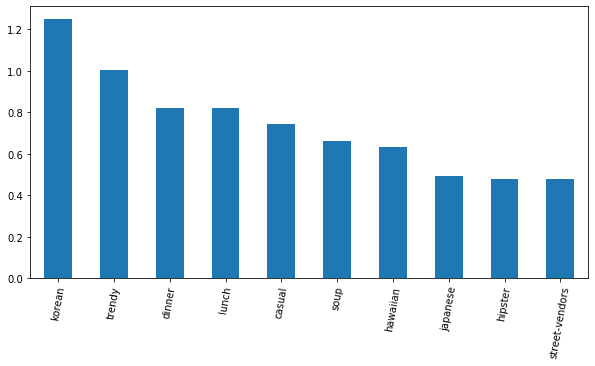

In [21]:
plt.rcParams['figure.figsize'] = [10, 5]
user_id_num = pd.read_parquet(fp + "/user_id_map.gzip")
which_rows = user_id_num["user_id"] == "Ksp1e9Dw0Jcog_ZBD3-45g"
user_id_num = user_id_num[which_rows]
plot_data = pd.read_parquet(fp + "/user_profile_weighted.gzip")
which_rows = plot_data["user_id"] == user_id_num["index"].values[0]
plot_data = plot_data[which_rows].squeeze()
plot_data = plot_data.drop("user_id").sort_values(ascending=False).head(10)
plot_data.plot.bar(x=plot_data.index, y=plot_data.values, rot=80)

In [22]:
plot_data = None